In [3]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from matplotlib.colors import ListedColormap

import re
import neurokit2 as nk

In [4]:
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.8
plt.rcParams['grid.linestyle'] = 'dotted'
plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams['figure.figsize'] = (4.845, 3.135)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['mathtext.default']='regular'

In [5]:
# data loading module
path_prefix = '../data'
class S1():
    def __init__(self):
        filenames = sorted(os.listdir(os.path.join(path_prefix, f'scenario_1/train/physiology')),
                           key=lambda s: (int(re.findall(r'(?<=sub_)\d+', s)[0]), int(re.findall(r'(?<=vid_)\d+', s)[0])))
        self.subs = list(set([int(re.findall(r'(?<=sub_)\d+', s)[0]) for s in filenames]))
        self.vids = list(set([int(re.findall(r'(?<=vid_)\d+', s)[0]) for s in filenames]))
        self.keys = ['ecg',' bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']
    
    def train_data(self, sub: int, vid: int):
        return pd.read_csv(os.path.join(path_prefix, f'scenario_1/train/physiology', f'sub_{sub}_vid_{vid}.csv'), index_col="time"), \
            pd.read_csv(os.path.join(path_prefix, f'scenario_1/train/annotations', f'sub_{sub}_vid_{vid}.csv'), index_col="time")
    
    def test_data(self, sub: int, vid: int):
        return pd.read_csv(os.path.join(path_prefix, f'scenario_1/test/physiology', f'sub_{sub}_vid_{vid}.csv'), index_col="time"), \
            pd.read_csv(os.path.join(path_prefix, f'scenario_1/test/annotations', f'sub_{sub}_vid_{vid}.csv'), index_col="time")

In [6]:
s1 = S1()
subs = s1.subs
vids = s1.vids

In [ ]:
# visualization of one subject for all videos
sub = subs[0]
vid_num = len(vids)
fig = plt.figure(figsize=(10, 4 * vid_num))
s1_train_data = []
for vid in vids:
    s1_train_data.append(s1.train_data(sub, vid))
max_length = np.max([len(s1_train_data[i][0]) for i in range(vid_num)])
max_value = np.max([[np.max(s1_train_data[i][1]['arousal']), np.max(s1_train_data[i][1]['valence'])] for i in range(vid_num)])

for i, vid in enumerate(vids):
    train_data = s1_train_data[i]
    signals, info = nk.ecg_process(train_data[0]['ecg'], sampling_rate=1000)
    
    ax = plt.subplot(vid_num, 1, i+1) 
    
    plt.xlim(0, max_length)
    plt.ylim(0, 12)
    plt.plot(signals['ECG_Raw'], label='ECG_Raw')
    plt.plot(signals['ECG_R_Peaks'], label='ECG_R_Peaks')
    plt.plot(signals['ECG_Clean'], label='ECG_Clean')
    plt.plot(signals['ECG_Rate']/10, label='Heart Rate')
    plt.plot(train_data[1]['arousal'], label='arousal')
    plt.plot(train_data[1]['valence'], label='valence')
    plt.title(f'Subject {sub}, Video {vid}')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# visualization of one video for all subjects
vid = vids[0]
sub_num = len(subs)
fig = plt.figure(figsize=(10, 4 * sub_num))
s1_train_data = []
for sub in subs:
    s1_train_data.append(s1.train_data(sub, vid))
max_length = np.max([len(s1_train_data[i][0]) for i in range(sub_num)])
max_value = np.max([[np.max(s1_train_data[i][1]['arousal']), np.max(s1_train_data[i][1]['valence'])] for i in range(sub_num)])

for i, sub in enumerate(subs):
    train_data = s1_train_data[i]
    signals, info = nk.ecg_process(train_data[0]['ecg'], sampling_rate=1000)
    
    ax = plt.subplot(sub_num, 1, i+1) 
    
    plt.xlim(0, max_length)
    plt.ylim(0, 12)
    plt.plot(signals['ECG_Raw'], label='ECG_Raw')
    plt.plot(signals['ECG_R_Peaks'], label='ECG_R_Peaks')
    plt.plot(signals['ECG_Clean'], label='ECG_Clean')
    plt.plot(signals['ECG_Rate']/10, label='Heart Rate')
    plt.plot(train_data[1]['arousal'], label='arousal')
    plt.plot(train_data[1]['valence'], label='valence')
    plt.title(f'Subject {sub}, Video {vid}')
    plt.legend()
plt.tight_layout()
plt.show()

In [91]:
def sliding_window_generator(data, window_size, step):
    splitted_data = []
    cur_index = 0
    while(cur_index + window_size <= len(data)):
        splitted_data.append(data[cur_index:cur_index + window_size])
        cur_index += 500
    if cur_index != len(data) and cur_index + window_size > len(data):
        splitted_data.append(data[cur_index:])
    return splitted_data

In [138]:
# generate the parameters for epochs creating
def epochs_info_generator(data, window_size, step):
    events_onset = []
    epochs_start = []
    epochs_end = []
    cur_index = 0
    while(cur_index + window_size <= len(data)):
        events_onset.append(cur_index)
        epochs_start.append(0)
        epochs_end.append(window_size / 1000)
        cur_index += 500
    if cur_index != len(data) and cur_index + window_size > len(data):
        events_onset.append(cur_index)
        epochs_start.append(0)
        epochs_end.append((len(data) - cur_index) / 1000)
        
    return events_onset, epochs_start, epochs_end

In [146]:
# loading data and processing
train_data = s1.train_data(1, 1)
ecg = train_data[0]['ecg']
annotations = train_data[1]
signals, info = nk.ecg_process(ecg, sampling_rate=1000)

In [147]:
# splitting sliding window
window_size = 2000
step = 500
events, epochs_start, epochs_end = epochs_info_generator(signals, window_size=window_size, step=step)
splitted_signals = nk.epochs_create(signals, events, sampling_rate=1000, epochs_start=epochs_start, epochs_end=epochs_end)

In [149]:
# extracting features
analyze_signal = nk.ecg_analyze(splitted_signals, sampling_rate=1000, method="event-related")
analyze_signal.columns

Index(['Label', 'Event_Onset', 'ECG_Rate_Baseline', 'ECG_Rate_Max',
       'ECG_Rate_Min', 'ECG_Rate_Mean', 'ECG_Rate_SD', 'ECG_Rate_Max_Time',
       'ECG_Rate_Min_Time', 'ECG_Rate_Trend_Linear',
       'ECG_Rate_Trend_Quadratic', 'ECG_Rate_Trend_R2', 'ECG_Phase_Atrial',
       'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
       'ECG_Phase_Completion_Ventricular', 'ECG_Quality_Mean'],
      dtype='object')

In [156]:
analyze_signal

,Label,Event_Onset,ECG_Rate_Baseline,ECG_Rate_Max,ECG_Rate_Min,ECG_Rate_Mean,ECG_Rate_SD,ECG_Rate_Max_Time,ECG_Rate_Min_Time,ECG_Rate_Trend_Linear,ECG_Rate_Trend_Quadratic,ECG_Rate_Trend_R2,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular,ECG_Quality_Mean
1,1,0,70.372561,11.819220,0.000000,4.664166,4.740960,1.592796,0.001001,7.870924,-2.667727,0.739148,NaN,0.000000,NaN,0.000000,0.774069
2,2,500,70.372561,11.819220,-4.858123,4.494582,5.126714,1.092546,2.000000,31.339840,-5.536118,0.868979,NaN,0.000000,NaN,0.000000,0.809010
3,3,1000,73.990463,8.201317,-12.065646,-0.941862,7.121142,0.592296,2.000000,3.933389,5.013701,0.877178,0.0,0.228995,1.0,0.400576,0.860464
4,4,1500,81.969566,0.222215,-21.607277,-13.402829,7.602010,0.092046,2.000000,-26.085896,3.711457,0.987243,1.0,0.256198,0.0,0.763780,0.916413
5,5,2000,75.307547,-0.025404,-14.945374,-10.913544,3.803923,0.001001,1.503752,-23.159450,-0.348135,0.965476,0.0,0.512531,0.0,0.107394,0.955684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,200,99500,69.825941,1.179976,-2.029331,-0.886890,1.192714,0.263132,1.148574,-4.479612,1.786295,0.846653,0.0,0.807479,0.0,0.469512,0.713559
201,201,100000,70.416799,0.902900,-2.620189,-1.799735,0.888009,2.000000,0.648324,-5.542651,-0.090334,0.950267,0.0,0.312746,1.0,0.681948,0.810570
202,202,100500,68.025809,7.351076,-0.229199,1.805834,2.620274,1.822911,0.148074,-4.119575,0.532202,0.977353,0.0,0.969777,0.0,0.726592,0.883107
203,203,101000,67.888985,7.487899,0.000515,3.827403,3.164452,1.322661,0.001001,5.162757,-1.380001,0.909071,0.0,0.465699,0.0,0.013183,0.924065


In [151]:
features = ['ECG_Rate_Baseline', 'ECG_Rate_Max',
       'ECG_Rate_Min', 'ECG_Rate_Mean', 'ECG_Rate_SD', 'ECG_Rate_Max_Time',
       'ECG_Rate_Min_Time', 'ECG_Rate_Trend_Linear',
       'ECG_Rate_Trend_Quadratic', 'ECG_Rate_Trend_R2', 'ECG_Phase_Atrial',
       'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
       'ECG_Phase_Completion_Ventricular', 'ECG_Quality_Mean']

In [154]:
colors = ListedColormap(sns.color_palette('deep')).colors

arousal_color = colors[0]
valence_color = colors[1]
bg_color = ListedColormap(sns.color_palette('Greys', 4)).colors[0]
signal_color = ListedColormap(sns.color_palette('Greens', 4)).colors[3]

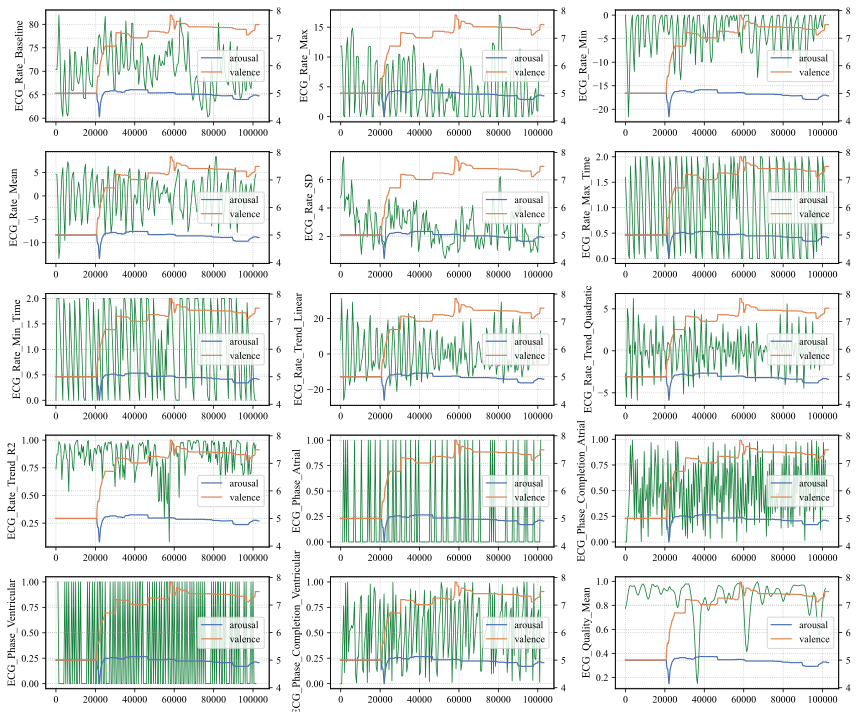

In [155]:
width_per_figure = 4
height_per_figure = 2
n_row = 5
n_column = 3
fig, axes = plt.subplots(n_row, n_column, figsize=(width_per_figure * n_column, height_per_figure * n_row))
axes = axes.flatten()
for i, feature in enumerate(features):
    axes[i].set_ylabel(f'{feature}')
    axes[i].plot(analyze_signal['Event_Onset'], analyze_signal[feature].to_numpy(), color=signal_color, linewidth=0.8)
    ax2 = plt.twinx(axes[i])
    ax2.plot(annotations['arousal'], label='arousal', color=arousal_color, linewidth=1.2)
    ax2.plot(annotations['valence'], label='valence', color=valence_color, linewidth=1.2)
#     ax2.set_ylabel('Arousal and Valence')
    plt.legend()
plt.tight_layout();